<a href="https://colab.research.google.com/github/bala-codes/Mini_Word_Embeddings/blob/master/codes/Mini_Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import torch 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import random
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
!pip install torchsummaryX  --quiet
from torchsummaryX import summary

In [158]:
# Sample Document # Recreated from the tom and jerry cartoon
        
docs = ["cat and mice are buddies",
        'mice lives in hole',
        'cat lives in house',
        'cat chases mice',
        'cat catches mice',
        'cat eats mice',
        'mice runs into hole',
        'cat says bad words',
        'cat and mice are pals',
        'cat and mice are chums',
        'mice stores food in hole',
        'cat stores food in house',
        'mice sleeps in hole',
        'cat sleeps in house']

In [159]:
idx_2_word = {}
word_2_idx = {}
temp = []
i = 1
for doc in docs:
  for word in doc.split():
    if word not in temp:
      temp.append(word)
      idx_2_word[i] = word
      word_2_idx[word] = i
      i += 1

print(idx_2_word)
print(word_2_idx)

{1: 'cat', 2: 'and', 3: 'mice', 4: 'are', 5: 'buddies', 6: 'lives', 7: 'in', 8: 'hole', 9: 'house', 10: 'chases', 11: 'catches', 12: 'eats', 13: 'runs', 14: 'into', 15: 'says', 16: 'bad', 17: 'words', 18: 'pals', 19: 'chums', 20: 'stores', 21: 'food', 22: 'sleeps'}
{'cat': 1, 'and': 2, 'mice': 3, 'are': 4, 'buddies': 5, 'lives': 6, 'in': 7, 'hole': 8, 'house': 9, 'chases': 10, 'catches': 11, 'eats': 12, 'runs': 13, 'into': 14, 'says': 15, 'bad': 16, 'words': 17, 'pals': 18, 'chums': 19, 'stores': 20, 'food': 21, 'sleeps': 22}


# Words to numbers

In [160]:
vocab_size = 25

def one_hot_map(doc):
  x = []
  for word in doc.split():
    x.append(word_2_idx[word])
  return x
  
encoded_docs = [one_hot_map(d) for d in docs]
encoded_docs

[[1, 2, 3, 4, 5],
 [3, 6, 7, 8],
 [1, 6, 7, 9],
 [1, 10, 3],
 [1, 11, 3],
 [1, 12, 3],
 [3, 13, 14, 8],
 [1, 15, 16, 17],
 [1, 2, 3, 4, 18],
 [1, 2, 3, 4, 19],
 [3, 20, 21, 7, 8],
 [1, 20, 21, 7, 9],
 [3, 22, 7, 8],
 [1, 22, 7, 9]]

# Padding

In [161]:
max_len = 10
padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
padded_docs

array([[ 1,  2,  3,  4,  5,  0,  0,  0,  0,  0],
       [ 3,  6,  7,  8,  0,  0,  0,  0,  0,  0],
       [ 1,  6,  7,  9,  0,  0,  0,  0,  0,  0],
       [ 1, 10,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 11,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 12,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 3, 13, 14,  8,  0,  0,  0,  0,  0,  0],
       [ 1, 15, 16, 17,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  3,  4, 18,  0,  0,  0,  0,  0],
       [ 1,  2,  3,  4, 19,  0,  0,  0,  0,  0],
       [ 3, 20, 21,  7,  8,  0,  0,  0,  0,  0],
       [ 1, 20, 21,  7,  9,  0,  0,  0,  0,  0],
       [ 3, 22,  7,  8,  0,  0,  0,  0,  0,  0],
       [ 1, 22,  7,  9,  0,  0,  0,  0,  0,  0]], dtype=int32)

# Creating dataset tuples for training

In [162]:
training_data = np.empty((0,2))

window = 2
for sentence in padded_docs:
  sent_len = len(sentence)
  for i, word in enumerate(sentence):
    w_context = []
    if sentence[i] != 0:
      w_target = sentence[i]
      for j in range(i-window, i + window + 1):
        if j != i and j <= sent_len -1 and j >=0 and sentence[j]!=0:
          w_context = sentence[j]
          training_data = np.append(training_data, [[w_target, w_context]], axis=0)
          #training_data.append([w_target, w_context])

print(len(training_data))
print(training_data.shape)
training_data

148
(148, 2)


array([[ 1.,  2.],
       [ 1.,  3.],
       [ 2.,  1.],
       [ 2.,  3.],
       [ 2.,  4.],
       [ 3.,  1.],
       [ 3.,  2.],
       [ 3.,  4.],
       [ 3.,  5.],
       [ 4.,  2.],
       [ 4.,  3.],
       [ 4.,  5.],
       [ 5.,  3.],
       [ 5.,  4.],
       [ 3.,  6.],
       [ 3.,  7.],
       [ 6.,  3.],
       [ 6.,  7.],
       [ 6.,  8.],
       [ 7.,  3.],
       [ 7.,  6.],
       [ 7.,  8.],
       [ 8.,  6.],
       [ 8.,  7.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 6.,  1.],
       [ 6.,  7.],
       [ 6.,  9.],
       [ 7.,  1.],
       [ 7.,  6.],
       [ 7.,  9.],
       [ 9.,  6.],
       [ 9.,  7.],
       [ 1., 10.],
       [ 1.,  3.],
       [10.,  1.],
       [10.,  3.],
       [ 3.,  1.],
       [ 3., 10.],
       [ 1., 11.],
       [ 1.,  3.],
       [11.,  1.],
       [11.,  3.],
       [ 3.,  1.],
       [ 3., 11.],
       [ 1., 12.],
       [ 1.,  3.],
       [12.,  1.],
       [12.,  3.],
       [ 3.,  1.],
       [ 3., 12.],
       [ 3.,

In [163]:
enc = OneHotEncoder()
enc.fit(np.array(range(30)).reshape(-1,1))
onehot_label_x = enc.transform(training_data[:,0].reshape(-1,1)).toarray()
onehot_label_x

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [164]:
enc = OneHotEncoder()
enc.fit(np.array(range(30)).reshape(-1,1))
onehot_label_y = enc.transform(training_data[:,1].reshape(-1,1)).toarray()
onehot_label_y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [165]:
print(onehot_label_x[0])
print(onehot_label_y[0])

# From Numpy to Torch

onehot_label_x = torch.from_numpy(onehot_label_x)
onehot_label_y = torch.from_numpy(onehot_label_y)
print(onehot_label_x.shape, onehot_label_y.shape)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
torch.Size([148, 30]) torch.Size([148, 30])


In [166]:
class WEMB(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(WEMB, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.softmax = nn.Softmax(dim=1)
    
    self.l1 = nn.Linear(self.input_size, self.hidden_size, bias=False)
    self.l2 = nn.Linear(self.hidden_size, self.input_size, bias=False)
   
  def forward(self, x):
    out_bn = self.l1(x) # bn - bottle_neck
    out = self.l2(out_bn)
    out = self.softmax(out)
    return out, out_bn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [167]:
'''
m = nn.Softmax() #nn.Sigmoid()
loss = nn.BCELoss()
input = torch.tensor([0.9,0.0,0.0]) #torch.randn(3, requires_grad=True)
target = torch.tensor([1.0,0.0,0.0])
output = loss(m(input), target)
print(input, m(input), target) tensor([0.9000, 0.0000, 0.0000]) tensor([0.5515, 0.2242, 0.2242]) tensor([1., 0., 0.])
output -> 0.36
'''

'''
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.tensor([0.9,0.0,0.0])
target = torch.tensor([1.0,0.0,0.0])
output = loss(m(input), target)
print(input, m(input), target) tensor([0.9000, 0.0000, 0.0000]) tensor([0.7109, 0.5000, 0.5000]) tensor([1., 0., 0.])
output -> 0.5758
'''

'\nm = nn.Sigmoid()\nloss = nn.BCELoss()\ninput = torch.tensor([0.9,0.0,0.0])\ntarget = torch.tensor([1.0,0.0,0.0])\noutput = loss(m(input), target)\nprint(input, m(input), target) tensor([0.9000, 0.0000, 0.0000]) tensor([0.7109, 0.5000, 0.5000]) tensor([1., 0., 0.])\noutput -> 0.5758\n'

In [172]:
input_size = 30
hidden_size = 2
learning_rate = 0.01
num_epochs = 10000

untrained_model = WEMB(input_size, hidden_size).to(device)
model = WEMB(input_size, hidden_size).to(device)
model.train(True)
print(model)
print()

# Loss and optimizer
criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0, dampening=0, weight_decay=0, nesterov=False)
summary(model, torch.ones((1,30))) 

WEMB(
  (softmax): Softmax(dim=1)
  (l1): Linear(in_features=30, out_features=2, bias=False)
  (l2): Linear(in_features=2, out_features=30, bias=False)
)

          Kernel Shape Output Shape Params Mult-Adds
Layer                                               
0_l1           [30, 2]       [1, 2]   60.0      60.0
1_l2           [2, 30]      [1, 30]   60.0      60.0
2_softmax            -      [1, 30]      -         -
------------------------------------------------------
                      Totals
Total params           120.0
Trainable params       120.0
Non-trainable params     0.0
Mult-Adds              120.0


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_l1,"[30, 2]","[1, 2]",60.0,60.0
1_l2,"[2, 30]","[1, 30]",60.0,60.0
2_softmax,-,"[1, 30]",NaN,NaN


Epoch [100/10000], Loss: 0.1461
Epoch [200/10000], Loss: 0.1448
Epoch [300/10000], Loss: 0.1427
Epoch [400/10000], Loss: 0.1397
Epoch [500/10000], Loss: 0.1355
Epoch [600/10000], Loss: 0.1302
Epoch [700/10000], Loss: 0.1241
Epoch [800/10000], Loss: 0.1177
Epoch [900/10000], Loss: 0.1112
Epoch [1000/10000], Loss: 0.1051
Epoch [1100/10000], Loss: 0.0998
Epoch [1200/10000], Loss: 0.0953
Epoch [1300/10000], Loss: 0.0917
Epoch [1400/10000], Loss: 0.0887
Epoch [1500/10000], Loss: 0.0863
Epoch [1600/10000], Loss: 0.0844
Epoch [1700/10000], Loss: 0.0828
Epoch [1800/10000], Loss: 0.0814
Epoch [1900/10000], Loss: 0.0802
Epoch [2000/10000], Loss: 0.0791
Epoch [2100/10000], Loss: 0.0781
Epoch [2200/10000], Loss: 0.0772
Epoch [2300/10000], Loss: 0.0763
Epoch [2400/10000], Loss: 0.0755
Epoch [2500/10000], Loss: 0.0746
Epoch [2600/10000], Loss: 0.0738
Epoch [2700/10000], Loss: 0.0729
Epoch [2800/10000], Loss: 0.0720
Epoch [2900/10000], Loss: 0.0711
Epoch [3000/10000], Loss: 0.0702
Epoch [3100/10000],

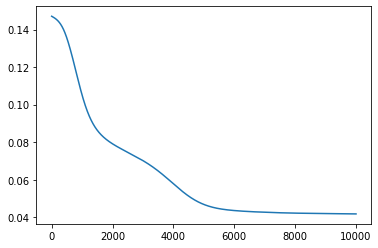

In [173]:
loss_val = []
onehot_label_x = onehot_label_x.to(device)
onehot_label_y = onehot_label_y.to(device)

for epoch in range(num_epochs):
  for i in range(onehot_label_y.shape[0]):
      inputs = onehot_label_x[i].float()
      labels = onehot_label_y[i].float()
      inputs = inputs.unsqueeze(0)
      labels = labels.unsqueeze(0)

      # Forward pass
      output, wemb = model(inputs)
      loss = criterion(output, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  loss_val.append(loss.item())

  if (epoch+1) % 100 == 0:
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_val)

In [174]:
docs = ['cat and mice are buddies hole lives in house chases catches runs into says bad words pals chums stores sleeps']
encoded_docs = [one_hot_map(d) for d in docs]

test_arr = np.array([[ 1.,  2., 3., 4., 5., 8., 6., 7., 9., 10., 11., 13., 14., 15., 16., 17., 18., 19., 20., 22.]])
test = enc.transform(test_arr.reshape(-1,1)).toarray()

output = []
for i in range(test.shape[0]):
  _, wemb2 = model(torch.from_numpy(test[i]).unsqueeze(0).float())
  wemb2 = wemb2[0].detach().cpu().numpy()
  output.append(wemb2)
print(len(output))
print(output)

20
[array([-0.31606016,  0.47879812], dtype=float32), array([0.11870998, 3.704355  ], dtype=float32), array([-0.02647777,  0.58047426], dtype=float32), array([-2.7212205 , -0.15240875], dtype=float32), array([-0.8489188,  1.7500181], dtype=float32), array([2.3317266 , 0.27839568], dtype=float32), array([0.64955014, 2.5612757 ], dtype=float32), array([0.3878987, 1.1554354], dtype=float32), array([2.8160677, 0.6257389], dtype=float32), array([0.08442795, 2.9699514 ], dtype=float32), array([0.08744251, 2.9864902 ], dtype=float32), array([-0.10781598,  0.87140197], dtype=float32), array([-0.10247965,  0.87923723], dtype=float32), array([ 1.86401   , -0.57549864], dtype=float32), array([ 1.4402062 , -0.50253433], dtype=float32), array([ 0.3084917, -2.6867192], dtype=float32), array([-0.8497961,  1.744398 ], dtype=float32), array([-0.84921193,  1.7490457 ], dtype=float32), array([0.8418646, 2.1882472], dtype=float32), array([0.6494018, 2.5602448], dtype=float32)]


In [154]:
docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives', 'in', 'house', 'chases', 'catches', 'runs', 'into', 'says', 'bad', 'words', 'pals', 'chums', 'stores', 'sleeps']
for i in range(0, len(docs)):
  print("Word - {} - It's Word Embeddings : {:.3} & {:.3} -".format(docs[i], output[i][0], output[i][0]))

Word - cat - It's Word Embeddings : -0.0428 & -0.0428 -
Word - and - It's Word Embeddings : -0.152 & -0.152 -
Word - mice - It's Word Embeddings : 0.113 & 0.113 -
Word - are - It's Word Embeddings : -0.151 & -0.151 -
Word - buddies - It's Word Embeddings : -0.121 & -0.121 -
Word - hole - It's Word Embeddings : -0.0583 & -0.0583 -
Word - lives - It's Word Embeddings : 0.116 & 0.116 -
Word - in - It's Word Embeddings : 0.0778 & 0.0778 -
Word - house - It's Word Embeddings : 0.0933 & 0.0933 -
Word - chases - It's Word Embeddings : 0.00153 & 0.00153 -
Word - catches - It's Word Embeddings : -0.119 & -0.119 -
Word - runs - It's Word Embeddings : -0.0713 & -0.0713 -
Word - into - It's Word Embeddings : 0.0398 & 0.0398 -
Word - says - It's Word Embeddings : 0.104 & 0.104 -
Word - bad - It's Word Embeddings : 0.151 & 0.151 -
Word - words - It's Word Embeddings : 0.169 & 0.169 -
Word - pals - It's Word Embeddings : -0.0761 & -0.0761 -
Word - chums - It's Word Embeddings : -0.124 & -0.124 -
Word

[-0.77174056, -2.6975653, -0.7440629, -1.3513004, -1.8827567, -0.9547955, -1.5381078, -0.78968775, -1.6798445, -2.4089494, -2.4038322, -0.4912264, -0.46597198, -0.6022128, -0.5429058, 0.30888712, -1.8706342, -1.8906851, -1.8495681, -1.5377734] [-0.26284522, -1.3949245, -0.18110614, -1.5926436, -0.79568034, 1.2527305, 2.2406118, 1.4590931, 2.1471748, -0.12073173, -0.11152688, 1.0223488, 1.0968646, -1.6286496, -1.3965739, -2.1094017, -0.7624414, -0.8023815, 1.6694156, 2.2398808]


<Figure size 432x288 with 0 Axes>

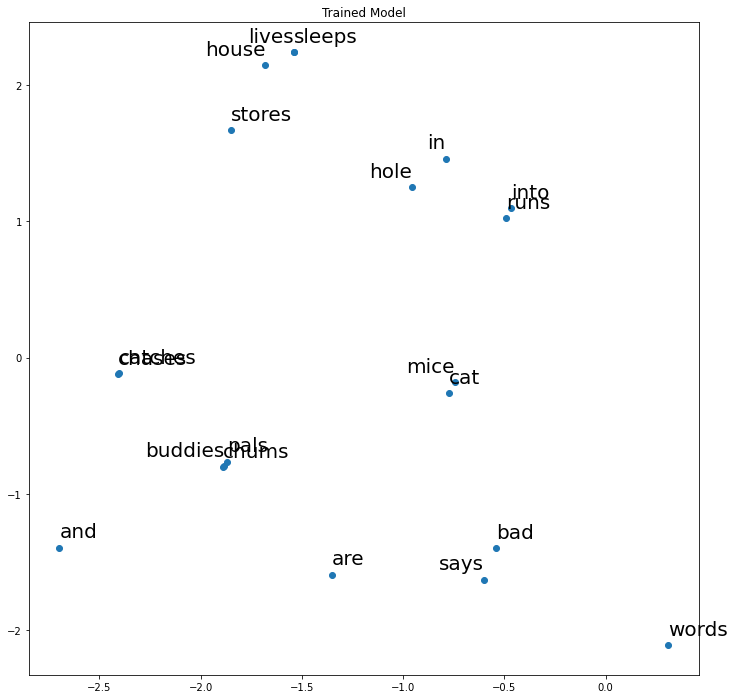

In [122]:
xs = []
ys = []
for i in range(len(output)):
  xs.append(output[i][0])
  ys.append(output[i][1])
print(xs, ys)

docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives', 'in', 'house', 'chases', 'catches', 'runs', 'into', 'says', 'bad', 'words', 'pals', \
        'chums', 'stores', 'sleeps']

plt.clf()
plt.figure(figsize=(12,12))
plt.scatter(xs,ys)
label = docs

for i,(x,y) in enumerate(zip(xs,ys)):
  plt.annotate(label[i], (x,y), textcoords="offset points", xytext=(0,10), fontsize=20, ha = random.choice(['left', 'right']))
  plt.title("Trained Model")
plt.show()

In [121]:
import plotly
import plotly.express as px

import plotly.express as px
fig = px.scatter(x=xs, y=ys, text=docs, size_max=100)
fig.update_traces(textposition= random.choice(['top center', 'bottom center','bottom left']))
fig.update_layout(height=800,title_text='Custom Word Embeddings')
fig.show()

# How Untrained Model behaves with our data

20
[array([-0.04275345, -0.02886879], dtype=float32), array([-0.15202194,  0.07314789], dtype=float32), array([ 0.11291146, -0.02519633], dtype=float32), array([-0.15067662, -0.03637494], dtype=float32), array([-0.12090125, -0.12671636], dtype=float32), array([-0.05830668, -0.06250159], dtype=float32), array([ 0.11598429, -0.17297596], dtype=float32), array([ 0.07779913, -0.16202387], dtype=float32), array([ 0.09326096, -0.08127425], dtype=float32), array([0.00153296, 0.10262998], dtype=float32), array([-0.11948875, -0.08580889], dtype=float32), array([-0.07129273,  0.11963926], dtype=float32), array([ 0.03983977, -0.10740042], dtype=float32), array([0.10391836, 0.05241726], dtype=float32), array([ 0.15077467, -0.16078997], dtype=float32), array([ 0.16935094, -0.10312367], dtype=float32), array([-0.07607429,  0.14855856], dtype=float32), array([-0.12368356,  0.07868253], dtype=float32), array([-0.01665527, -0.15915565], dtype=float32), array([0.12776056, 0.09338955], dtype=float32)]
[-

<Figure size 432x288 with 0 Axes>

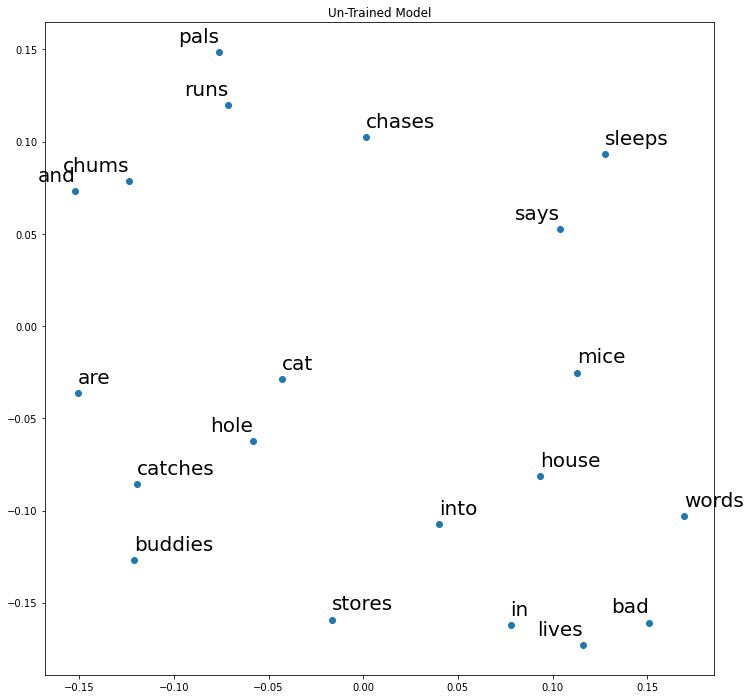

In [124]:
output = []
for i in range(test.shape[0]):
  _, wemb2 = untrained_model(torch.from_numpy(test[i]).unsqueeze(0).float()) # Here I am loading the untrained model
  wemb2 = wemb2[0].detach().cpu().numpy()
  output.append(wemb2)
print(len(output))
print(output)

xs = []
ys = []
for i in range(len(output)):
  xs.append(output[i][0])
  ys.append(output[i][1])
print(xs, ys)

docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives', 'in', 'house', 'chases', 'catches', 'runs', 'into', 'says', 'bad', 'words', 'pals', \
        'chums', 'stores', 'sleeps']

plt.clf()
plt.figure(figsize=(12,12))
plt.scatter(xs,ys)
label = docs

for i,(x,y) in enumerate(zip(xs,ys)):
  plt.annotate(label[i], (x,y), textcoords="offset points", xytext=(0,10), fontsize=20, ha = random.choice(['left', 'right']))
  plt.title("Un-Trained Model")
plt.show()

In [125]:
import plotly
import plotly.express as px

import plotly.express as px
fig = px.scatter(x=xs, y=ys, text=docs, size_max=100)
fig.update_traces(textposition= random.choice(['top center', 'bottom center','bottom left']))
fig.update_layout(height=800,title_text='Custom Word Embeddings')
fig.show()